# Spam Classification (Naive Bayes Classifier)

In [1]:
import json
import numpy as np
import pandas as pd
import os
from numpy import random

from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook as progressbar

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

plt.rcParams['figure.figsize'] = [9, 6]

In [2]:
def load_json_from_file(filename):
    with open(filename, "r", encoding="utf-8") as f:
        return json.load(f)

In [3]:
emails_tokenized_ham = load_json_from_file("C:\dev\GL Basecamp\Spam Classifier\emails-tokenized-ham.json")
emails_tokenized_spam = load_json_from_file("C:\dev\GL Basecamp\Spam Classifier\emails-tokenized-spam.json")
vocab = load_json_from_file("vocab.json")

In [4]:
import itertools
vocab_set = set(itertools.chain(*emails_tokenized_ham)).union(set(itertools.chain(*emails_tokenized_spam)))

In [5]:
vocab = {
    word: index
    for index, word in enumerate(sorted(list(vocab_set)))
}

#### First time of vectorization - BoW - Bag of words

Create 2D-matrix with number of occurrences any word from dictionary in any letter from data

In [6]:
def email_to_vector_bow(email_words, vocab):
    email_vec = np.zeros(len(vocab), dtype="int32")
    
    for word in email_words:
        email_vec[vocab[word]] = email_vec[vocab[word]]+1   # here was the mistake that drove me crazy - email_vec[vocab[word]]=1
     #really terrible when mistakes happen in the beginnig of the program       
    return email_vec

In [7]:
X_1 = [
    email_to_vector_bow(email, vocab)
    for email in emails_tokenized_ham + emails_tokenized_spam
]
print(len(emails_tokenized_ham + emails_tokenized_spam)) # number of letters
print(len(vocab)) # size of dictionary, total amount of unique words
print(np.shape(X_1))# result - 2D-matrix where (i,j) is number of word j in letter 

5542
34133
(5542, 34133)


#### Second type of vectorization - Multinomial

Create vector of arrays, each array contains ID's of words from dictionary

In [8]:
def email_to_vector_multinomial(email_words, vocab):
    
    return np.array([vocab[word] for word in email_words], dtype="int32")

In [9]:
X_2 = [
    email_to_vector_multinomial(email, vocab)
    for email in emails_tokenized_ham + emails_tokenized_spam
]
print(emails_tokenized_ham[0][0]) # first word of ham emails
print(vocab[emails_tokenized_ham[0][0]]) # id of the word "date" in the vocabulary
print(len(emails_tokenized_ham + emails_tokenized_spam)) # number of letters
print(X_2[0][:7]) #part of array of id's of the first letter
print(np.shape(X_2)) # result - vector of arrays of id's of letters

date
6753
5542
[ 6753 32387 20419  1845 20419 20419 20419]
(5542,)


In [10]:
s = 0
print(sum(sum(X_1))) #to check that vectorization is correct
for row in X_2:
    s = s + len(row)
s

1520414


1520414

In [11]:
y = np.array([0] * len(emails_tokenized_ham) + [1] * len(emails_tokenized_spam))
len(y) # result list is the same for each vectorization

5542

Second type of vectorization takes up much less space, first type is really sparse. So the second type of vectorization is much better, despite the fact that its implementation does not immediately come to mind.

## Train model 

In [12]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_1, y, test_size=0.1, random_state=42) #first vectorization BoW
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_2, y, test_size=0.1, random_state=42) #second vectorization Mult

In [16]:
ham_total_words_train = sum(sum(email) for email, cls in zip(X_train1, y_train1) if cls == 0)
spam_total_words_train = sum(sum(email) for email, cls in zip(X_train1, y_train1) if cls == 1) # this 2 rows take some time

print("Ham ", ham_total_words_train, ", spam ", spam_total_words_train)

ham_total_words_train2 = sum(len(email) for email, cls in zip(X_train2, y_train2) if cls == 0)
spam_total_words_train2 = sum(len(email) for email, cls in zip(X_train2, y_train2) if cls == 1)

print("Ham ", ham_total_words_train2, ", spam ", spam_total_words_train2)

Ham  796332 , spam  573036
Ham  796332 , spam  573036


#### A priori probabilities for each class:

In [17]:
ham_email_indices = np.where(y_train1 == 0)[0]
spam_email_indices = np.where(y_train1 == 1)[0]

ham_log_prior = np.log(len(ham_email_indices) / len(y_train1))
spam_log_prior = np.log(len(spam_email_indices) / len(y_train1))

print(ham_log_prior)
print(spam_log_prior)

-0.3407323507725008
-1.2421914129760763


#### Likelihood for each word in the training set:

With first vectorization  

Huge size of this implementation takes lots of time to training

In [18]:
print(sum(X_train1[1]))
print(sum(X_train2[1]))
print(len(X_train2[1]))

93
1621905
93


In [45]:
%%time

ham_log_phi1 = np.zeros(len(vocab), dtype="float64")
spam_log_phi1 = np.zeros(len(vocab), dtype="float64")

ham_word_counts = np.zeros(len(vocab))
spam_word_counts = np.zeros(len(vocab))

for email_index in progressbar(range(len(X_train1)), desc="Train"):
    i = 0
    for word_index in X_train1[email_index]:
        if y_train1[email_index] == 0:
            ham_word_counts[i] += 1 * word_index # here was my second shop - weights of number of links and numbers are too significant
        if y_train1[email_index] == 1:
            spam_word_counts[i] += 1 * word_index #I hope that now it works correctly 
        i = i+1
print(sum(ham_word_counts), sum(spam_word_counts))
ham_log_phi1 = np.log((ham_word_counts + 1) / (ham_total_words_train + len(vocab)))
spam_log_phi1 = np.log((spam_word_counts + 1) / (spam_total_words_train + len(vocab)))

print(ham_log_phi1, spam_log_phi1)


796332.0 573036.0
[-10.53869861 -13.62974106 -13.62974106 ... -13.62974106 -13.62974106
 -13.62974106] [ -8.61608208 -11.11933787 -12.62341527 ... -13.31656245 -12.62341527
 -12.62341527]
Wall time: 4min 14s


With second vectorization

This implementation works significantly faster

In [47]:
%%time

ham_log_phi2 = np.zeros(len(vocab), dtype="float64")
spam_log_phi2 = np.zeros(len(vocab), dtype="float64")

ham_word_counts = np.zeros(len(vocab))
spam_word_counts = np.zeros(len(vocab))

for email_index in progressbar(range(len(X_train2)), desc="Train"):
    for word_index in X_train2[email_index]:
        if y_train2[email_index] == 0:
            ham_word_counts[word_index] += 1
        if y_train2[email_index] == 1:
            spam_word_counts[word_index] += 1
print(sum(ham_word_counts), sum(spam_word_counts))
ham_log_phi2 = np.log((ham_word_counts + 1) / (ham_total_words_train2 + len(vocab)))
spam_log_phi2 = np.log((spam_word_counts + 1) / (spam_total_words_train2 + len(vocab)))
print(ham_log_phi2, spam_log_phi2)
print(sum(ham_log_phi1 != ham_log_phi2))


796332.0 573036.0
[-10.53869861 -13.62974106 -13.62974106 ... -13.62974106 -13.62974106
 -13.62974106] [ -8.61608208 -11.11933787 -12.62341527 ... -13.31656245 -12.62341527
 -12.62341527]
0
Wall time: 2.11 s


### Predict

In [74]:
def predict(X):
    y_pred = np.zeros(len(X))
  # when I stop here, I understood, then usege of 
  # new metric in such way - is only my fault) 
  # now I'll find all my faults!
    for i in progressbar(range(len(y_pred)), desc="Predict"):
        email_vector = X[i]
        ham_sum = 0
        spam_sum = 0
        for ind,n in enumerate(email_vector):
            ham_sum += n * ham_log_phi1[ind] # mistake was here, I find it!!!
            spam_sum += n * spam_log_phi1[ind] # but the asymptotics of the solution increased significantly
        ham_posterior = ham_sum + ham_log_prior  # I was waited for prediction during 20 minutes) 
        spam_posterior = spam_sum + spam_log_prior

        y_pred[i] = 0 if ham_posterior > spam_posterior else 1 
    return y_pred

In [78]:
def predict2(X):
    y_pred = np.zeros(len(X))

    for i in progressbar(range(len(y_pred)), desc="Predict"):
        email_vector = X[i]
        ham_posterior = ham_log_phi2[email_vector].sum() + ham_log_prior
        spam_posterior = spam_log_phi2[email_vector].sum() + spam_log_prior

        y_pred[i] = 0 if ham_posterior > spam_posterior else 1
    return y_pred

In [75]:
pred_train = predict(X_train1) # this prediction takes 20 minutes to check)
pred_test = predict(X_test1) # maybe, sparse martices will save lots of time, I think I can make it 2 times faster, but not sure

accuracy_train = 1 - np.sum(pred_train != y_train1) / len(y_train1) 
accuracy_test = 1 - np.sum(pred_test != y_test1) / len(y_test1)

print("Training accuracy:   {0:.3f}%".format(accuracy_train * 100))
print("Test accuracy:       {0:.3f}%".format(accuracy_test * 100))


Training accuracy:   97.654%
Test accuracy:       97.477%


In [79]:
pred_train2 = predict2(X_train2)
pred_test2 = predict2(X_test2)

accuracy_train = 1 - np.sum(pred_train != y_train2) / len(y_train2)
accuracy_test = 1 - np.sum(pred_test != y_test2) / len(y_test2)

print("Training accuracy:   {0:.3f}%".format(accuracy_train * 100))
print("Test accuracy:       {0:.3f}%".format(accuracy_test * 100))


Training accuracy:   97.654%
Test accuracy:       97.477%


As we can see, accuracy of each methods of vectorization is equal. It was expected. But second type, without full matrix of emails and vocabulary is much much faster, because first type is too sparse

Also we can see, that model doesn't overfit, maybe this is nice property of out training algorithm

Soon I'll work just with one of the predicted set of data

[[405   0]
 [ 14 136]]


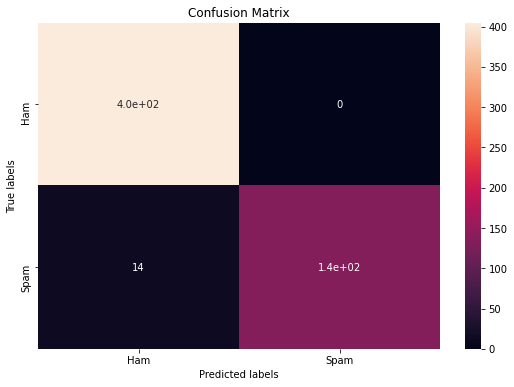

In [80]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test1, pred_test)
print(cm)

import seaborn as sns
labels = ['Ham','Spam']

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); 
ax.yaxis.set_ticklabels(labels);

## Evaluating

There are several metrics to evaluate our model 

TP - true positive predicion

FP - false positive(incorrect)

TN - true negative

FN - false negative(incorrect)

$$accuracy = \frac{TP + TN}{All} $$


$$precision = \frac{TP}{TP + FP} $$


$$recall = \frac{TP}{TP + FN} $$

$$F_\beta = (1+\beta^2) * \frac{precision * recall}{\beta^2*precision + recall}$$

In [92]:
from sklearn.metrics import classification_report
print(classification_report(y_test1,  pred_test, target_names = labels))

              precision    recall  f1-score   support

         Ham       0.97      1.00      0.98       405
        Spam       1.00      0.91      0.95       150

    accuracy                           0.97       555
   macro avg       0.98      0.95      0.97       555
weighted avg       0.98      0.97      0.97       555



Also exist ROC-curve, which show the performance of a binary classifier
But our classifier makes lack of mistakes, so our ROC curve looks strange 

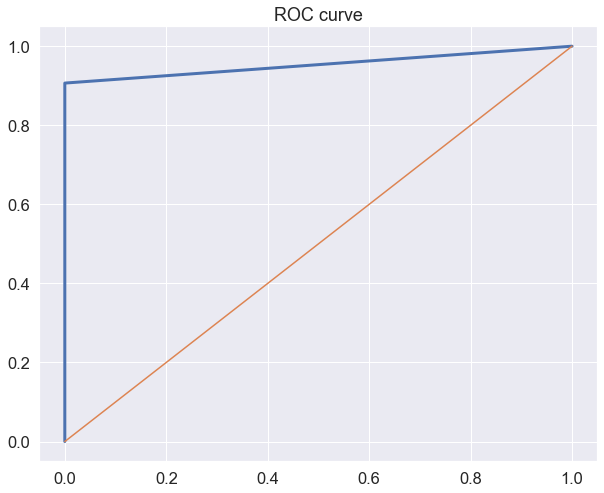

In [124]:
from sklearn.metrics import roc_curve
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds = roc_curve(y_test2, pred_test, pos_label=1)
lw = 3
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.title('ROC curve')
plt.show()

### Multinomial Naive Bayes from sklearn

Sklearn has a built-in model for training the multinomial naive Bayes algorithm. As we can see, the results of the prediction accuracy of out and built-in model are the same.

In [136]:
%%time

from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train1, y_train1)

y_mult = clf.predict(X_test1)

print(classification_report(y_test1, y_mult,target_names = labels))

              precision    recall  f1-score   support

         Ham       0.97      1.00      0.98       405
        Spam       1.00      0.91      0.95       150

    accuracy                           0.97       555
   macro avg       0.98      0.95      0.97       555
weighted avg       0.98      0.97      0.97       555

Wall time: 3.81 s
